In [1]:
import os
import urllib.parse

def open_default_mail_app(to, subject, body):
    try:
        mailto_url = f"mailto:{to}?subject={urllib.parse.quote(subject)}&body={urllib.parse.quote(body)}"
        os.system(f"rundll32.exe url.dll,FileProtocolHandler \"{mailto_url}\"")
    except Exception as e:
        print(f"Error opening mailto: {e}")

C:\Users\cheta\AppData\Local\Temp\ipykernel_10188\926512349.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


ARIMA - RMSE: 0.0022962049966052, MAE: 0.0019581056426615923


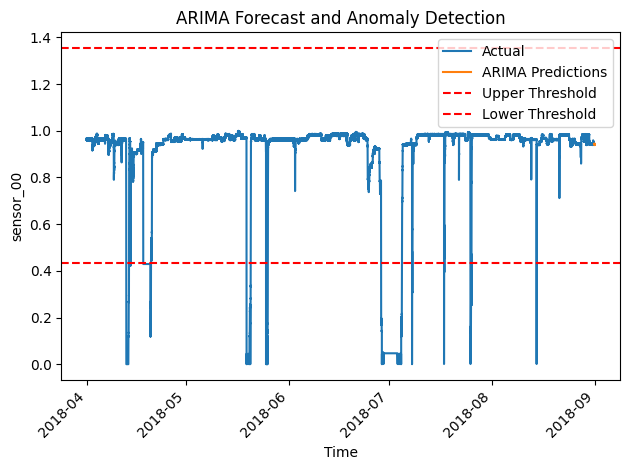

ARIMA model completed.
Detected anomalies:
0.0


In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import win32com.client
import os

df = pd.read_csv('sensor-data.csv', parse_dates=['timestamp'])
df.fillna(method='ffill', inplace=True)

target_sensor = 'sensor_00'
features = ['sensor_04', 'sensor_13', 'sensor_41', 'sensor_42'] 

scaler = MinMaxScaler()
df[features + [target_sensor]] = scaler.fit_transform(df[features + [target_sensor]])

upper_threshold = df[target_sensor].mean() +2 * df[target_sensor].std()
lower_threshold = df[target_sensor].mean() -2 * df[target_sensor].std()

model_arima = ARIMA(df[target_sensor], order=(5, 1, 0), exog=df[features])
fit_arima = model_arima.fit()

train_data = df[target_sensor][:-24]
test_data = df[target_sensor][-24:]

predictions_arima = fit_arima.predict(start=len(train_data), end=len(df) - 1, exog=df[features][-24:])

anomalies_arima = (predictions_arima > upper_threshold) | (predictions_arima < lower_threshold)

rmse_arima = np.sqrt(mean_squared_error(test_data, predictions_arima))
mae_arima = mean_absolute_error(test_data, predictions_arima)
print(f'ARIMA - RMSE: {rmse_arima}, MAE: {mae_arima}')

plt.plot(df['timestamp'], df[target_sensor], label='Actual')
plt.plot(df['timestamp'][-24:], predictions_arima, label='ARIMA Predictions')
plt.axhline(y=upper_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=lower_threshold, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.title("ARIMA Forecast and Anomaly Detection")
plt.xlabel('Time')
plt.xticks(rotation=45, ha='right')
plt.ylabel(target_sensor)
plt.tight_layout()
image_path = "images/arima_prediction.png"
plt.savefig(image_path)
plt.show()

anomaly_ratio = anomalies_arima.sum() / len(anomalies_arima)
anomaly_threshold = 0.2

anomaly_detected = anomaly_ratio >= anomaly_threshold 

if anomaly_detected:
    print("ALERT: High sensor anomaly ratio detected (ARIMA)! Check IoT device.")
    open_default_mail_app("chetankumarpulipati4@gmail.com","Alert","Check Sensors")
print("ARIMA model completed.") 
print("Detected anomalies:")

print(anomaly_ratio)

C:\Users\cheta\AppData\Local\Temp\ipykernel_10188\1785578652.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


AdaBoost - RMSE: 0.006942907422151733, MAE: 0.003005357520298577


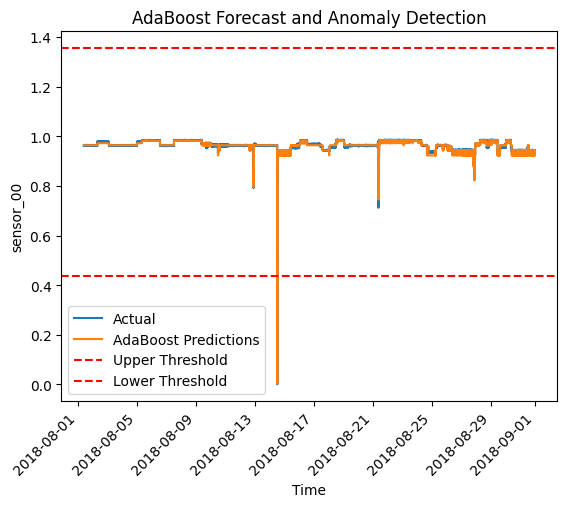

Adaboost model completed.
0.00020425300138438146


In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('sensor-data.csv', parse_dates=['timestamp'])
df.fillna(method='ffill', inplace=True)

target_sensor = 'sensor_00'
noise_level = 0.1
# df[target_sensor] += noise_level * np.random.randn(len(df))

features = ['sensor_04', 'sensor_13', 'sensor_41', 'sensor_42'] 

scaler = MinMaxScaler()
df[features + [target_sensor]] = scaler.fit_transform(df[features + [target_sensor]])

upper_threshold = df[target_sensor].mean() + 2 * df[target_sensor].std()
lower_threshold = df[target_sensor].mean() - 2 * df[target_sensor].std()

def create_lagged_features(data, lag=5):
    df_lagged = pd.DataFrame()
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = data.shift(i)
    df_lagged['target'] = data.values
    df_lagged.dropna(inplace=True)
    return df_lagged

lag = 5 
df_lagged = create_lagged_features(df[target_sensor], lag)

train_size = int(len(df_lagged) * 0.8) 
train_data = df_lagged[:train_size]
test_data = df_lagged[train_size:]

X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
X_test = test_data.drop('target', axis=1)
y_test = test_data['target']

adaboost_regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=50, random_state=42)
adaboost_regressor.fit(X_train, y_train)

predictions_adaboost = adaboost_regressor.predict(X_test)

anomalies_adaboost = (predictions_adaboost > upper_threshold) | (predictions_adaboost < lower_threshold)

rmse_adaboost = np.sqrt(mean_squared_error(y_test, predictions_adaboost))
mae_adaboost = mean_absolute_error(y_test, predictions_adaboost)
print(f'AdaBoost - RMSE: {rmse_adaboost}, MAE: {mae_adaboost}')

plt.plot(df['timestamp'].iloc[train_size+lag:], y_test, label='Actual') 
plt.plot(df['timestamp'].iloc[train_size+lag:], predictions_adaboost, label='AdaBoost Predictions')
plt.axhline(y=upper_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=lower_threshold, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.title("AdaBoost Forecast and Anomaly Detection")
plt.xlabel('Time')
plt.xticks(rotation=45, ha='right')
plt.ylabel(target_sensor)
image_path = "images/adaboost_prediction.png"
plt.savefig(image_path)
plt.show()

anomaly_ratio = anomalies_adaboost.sum() / len(anomalies_adaboost)
anomaly_threshold = 0.2

anomaly_detected = False 

if anomaly_ratio >= anomaly_threshold:
    anomaly_detected = True
    
if anomaly_detected:
    print("ALERT: High sensor anomaly ratio detected (AdaBoost)! Check IoT device.")
    open_default_mail_app("chetankumarpulipati4@gmail.com", "Maintenance required for sensor_00", "AdaBoost model predicted that the sensor is having abnormal patterns. Please schedule the maintenance.")

print("Adaboost model completed.")
print(anomaly_ratio)

C:\Users\cheta\AppData\Local\Temp\ipykernel_10188\1656249925.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


XGBoost - RMSE: 0.01452198911105547, MAE: 0.002208483706525643


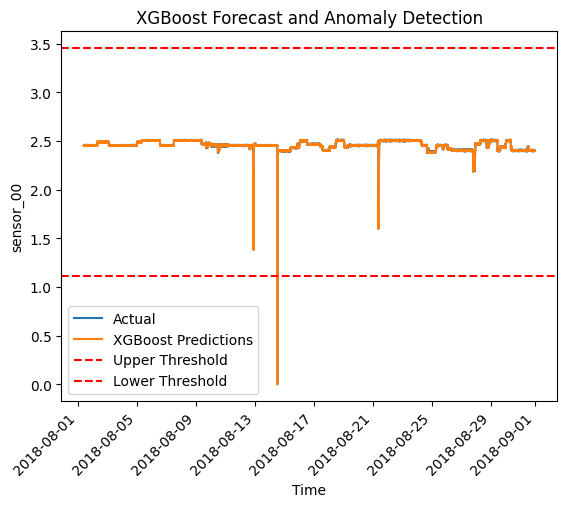

XGBoost model completed.
0.00020425300138438146


In [5]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText

# Read the data
df = pd.read_csv('sensor-data.csv', parse_dates=['timestamp'])
df.fillna(method='ffill', inplace=True)

# Set parameters
target_sensor = 'sensor_00'
noise_level = 0.1

# Calculate thresholds for anomaly detection
upper_threshold = df[target_sensor].mean() + 2 * df[target_sensor].std()
lower_threshold = df[target_sensor].mean() - 2 * df[target_sensor].std()

# Create lagged features
def create_lagged_features(data, lag=5):
    df_lagged = pd.DataFrame()
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = data.shift(i)
    df_lagged['target'] = data.values
    df_lagged.dropna(inplace=True)
    return df_lagged

# Create lagged data
lag = 5
df_lagged = create_lagged_features(df[target_sensor], lag)

# Split into train and test sets
train_size = int(len(df_lagged) * 0.8)
train_data = df_lagged[:train_size]
test_data = df_lagged[train_size:]

X_train = train_data.drop('target', axis=1)
y_train = train_data['target']
X_test = test_data.drop('target', axis=1)
y_test = test_data['target']

# Train the XGBoost regressor
xgboost_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgboost_regressor.fit(X_train, y_train)

# Predict using the trained model
predictions_xgboost = xgboost_regressor.predict(X_test)

# Detect anomalies
anomalies_xgboost = (predictions_xgboost > upper_threshold) | (predictions_xgboost < lower_threshold)

# Calculate evaluation metrics
rmse_xgboost = np.sqrt(mean_squared_error(y_test, predictions_xgboost))
mae_xgboost = mean_absolute_error(y_test, predictions_xgboost)
print(f'XGBoost - RMSE: {rmse_xgboost}, MAE: {mae_xgboost}')

# Plot results
plt.plot(df['timestamp'][train_size+lag:], y_test, label='Actual') 
plt.plot(df['timestamp'][train_size+lag:], predictions_xgboost, label='XGBoost Predictions')
plt.axhline(y=upper_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=lower_threshold, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.title("XGBoost Forecast and Anomaly Detection")
plt.xlabel('Time')
plt.xticks(rotation=45, ha='right')
plt.ylabel(target_sensor)
image_path = "images/xgboost_prediction.png"
plt.savefig(image_path)
plt.show()

# Check for anomalies
anomaly_ratio = anomalies_xgboost.sum() / len(anomalies_xgboost)
anomaly_threshold = 0.2

anomaly_detected = False 

if anomaly_ratio >= anomaly_threshold:
    anomaly_detected = True
    
if anomaly_detected:
    print("ALERT: High sensor anomaly ratio detected (XGBoost)! Check IoT device.")
    open_default_mail_app("chetankumarpulipati4@gmail.com", "Maintenance required for sensor_00", "XGBoost model predicted that the sensor is having abnormal patterns. Please schedule the maintenance.")
print("XGBoost model completed.")

print(anomaly_ratio)

C:\Users\cheta\AppData\Local\Temp\ipykernel_10188\3549376717.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
c:\Users\cheta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training DNN model...
11016/11016 ━━━━━━━━━━━━━━━━━━━━ 17s 1ms/step - loss: 0.0143
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
DNN - RMSE: 0.014779745714472674, MAE: 0.003933997134556684


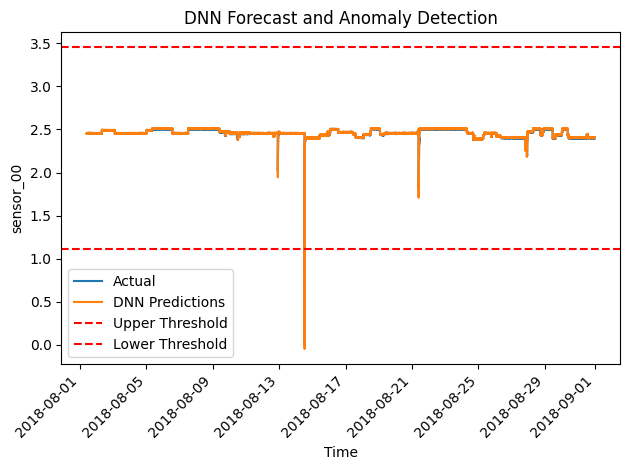

DNN model completed.
0.0002269477793159794


In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

df = pd.read_csv('sensor-data.csv', parse_dates=['timestamp'])
df.fillna(method='ffill', inplace=True)

target_sensor = 'sensor_00'
noise_level = 0.1
# df[target_sensor] += noise_level * np.random.randn(len(df))

upper_threshold = df[target_sensor].mean() + 2 * df[target_sensor].std()
lower_threshold = df[target_sensor].mean() - 2 * df[target_sensor].std()

def create_lagged_features(data, lag=5):
    df_lagged = pd.DataFrame()
    for i in range(1, lag + 1):
        df_lagged[f'lag_{i}'] = data.shift(i)
    df_lagged['target'] = data.values
    df_lagged.dropna(inplace=True)
    return df_lagged

lag = 5
df_lagged = create_lagged_features(df[target_sensor], lag)

train_size = int(len(df_lagged) * 0.8)
train_data = df_lagged[:train_size]
test_data = df_lagged[train_size:]

X_train = train_data.drop('target', axis=1).values
y_train = train_data['target'].values
X_test = test_data.drop('target', axis=1).values
y_test = test_data['target'].values


model = Sequential()
model.add(Dense(64, input_dim=lag, activation='relu')) 
model.add(Dense(32, activation='relu'))  
model.add(Dense(1))  

model.compile(optimizer='adam', loss='mse')

print("Training DNN model...")
model.fit(X_train, y_train, epochs=1, batch_size=16, verbose=1) 


predictions_dnn = model.predict(X_test).flatten()


anomalies_dnn = (predictions_dnn > upper_threshold) | (predictions_dnn < lower_threshold)


rmse_dnn = np.sqrt(mean_squared_error(y_test, predictions_dnn))
mae_dnn = mean_absolute_error(y_test, predictions_dnn)
print(f'DNN - RMSE: {rmse_dnn}, MAE: {mae_dnn}')


plt.plot(df['timestamp'][train_size+lag:], y_test, label='Actual') 
plt.plot(df['timestamp'][train_size+lag:], predictions_dnn, label='DNN Predictions')
plt.axhline(y=upper_threshold, color='r', linestyle='--', label='Upper Threshold')
plt.axhline(y=lower_threshold, color='r', linestyle='--', label='Lower Threshold')
plt.legend()
plt.title("DNN Forecast and Anomaly Detection")
plt.xlabel('Time')
plt.ylabel(target_sensor)
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
image_path = "images/dnn_prediction.png"
plt.savefig(image_path) 
plt.show()


anomaly_ratio = anomalies_dnn.sum() / len(anomalies_dnn)
anomaly_threshold = 0.2

anomaly_detected = False 

if anomaly_ratio >= anomaly_threshold:
    anomaly_detected = True
    
if anomaly_detected:
    print("ALERT: High sensor anomaly ratio detected (DNN)! Check IoT device.")
    open_default_mail_app("chetankumarpulipati4@gmail.com", "Maintenance required for sensor_00", "DNN model predicted that the sensor is having abnormal patterns. Please schedule the maintenance.")

print("DNN model completed.")
print(anomaly_ratio)

ARIMA - RMSE: 0.1112893166391527, MAE: 0.09524908987232869

AdaBoost - RMSE: 0.10851557124510754, MAE: 0.08567507794356481

XGBoost - RMSE: 0.10535357007976538, MAE: 0.08339478525669766

DNN - RMSE: 0.10954001732907882, MAE: 0.0862865659000907

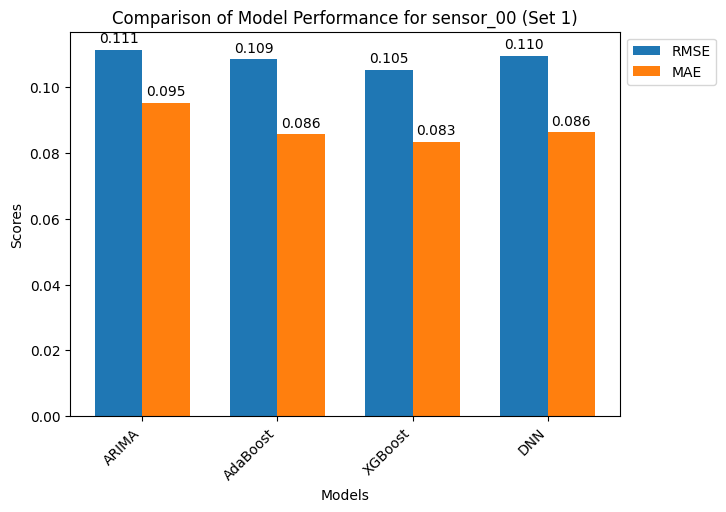

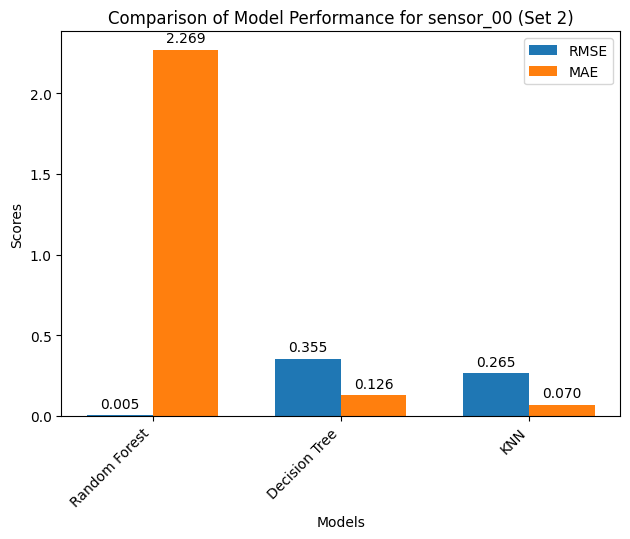

In [3]:
import matplotlib.pyplot as plt
import numpy as np

rmse_arima = 0.1112893166391527
mae_arima = 0.09524908987232869

rmse_adaboost = 0.10851557124510754
mae_adaboost = 0.08567507794356481

rmse_xgboost = 0.10535357007976538
mae_xgboost = 0.08339478525669766

rmse_dnn = 0.10954001732907882
mae_dnn = 0.0862865659000907

rmse_random_forest = 0.004763849587291912
mae_random_forest = 2.269426289034132

rmse_dt = 0.3554
mae_dt = 0.1263

rmse_knn = 0.2646831871171338
mae_knn = 0.07005718954248366

models_set1 = ['ARIMA', 'AdaBoost', 'XGBoost', 'DNN']
rmse_scores_set1 = [rmse_arima, rmse_adaboost, rmse_xgboost, rmse_dnn]
mae_scores_set1 = [mae_arima, mae_adaboost, mae_xgboost, mae_dnn]

models_set2 = ['Random Forest', 'Decision Tree', 'KNN']
rmse_scores_set2 = [rmse_random_forest, rmse_dt, rmse_knn]
mae_scores_set2 = [mae_random_forest, mae_dt, mae_knn]

def add_value_labels(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

x = np.arange(len(models_set1))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse_scores_set1, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_scores_set1, width, label='MAE')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance for sensor_00 (Set 1)')
ax.set_xticks(x)
ax.set_xticklabels(models_set1)
ax.legend()

add_value_labels(ax, rects1)
add_value_labels(ax, rects2)

fig.tight_layout()
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  
plt.savefig('New Models Bar')
plt.show()

x = np.arange(len(models_set2))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse_scores_set2, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_scores_set2, width, label='MAE')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance for sensor_00 (Set 2)')
ax.set_xticks(x)
ax.set_xticklabels(models_set2)
ax.legend()

add_value_labels(ax, rects1)
add_value_labels(ax, rects2)

fig.tight_layout()
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.savefig('Old Models Bar')
plt.show()